In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
session = Session(engine)
measure_first_row = session.query(measurement).first()
measure_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25a737ff5e0>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01'}

In [13]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent

('2017-08-23',)

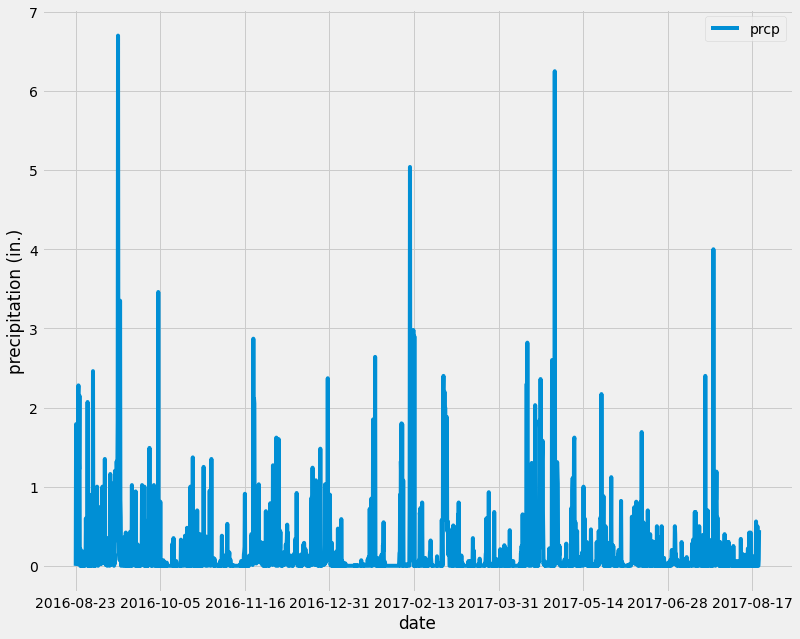

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
last_dt = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()
date_oneyearago = last_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).\
            filter((measurement.date >= date_oneyearago)\
                    & (measurement.date <= last_dt)).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data).sort_values("date").set_index("date")

# Sort the dataframe by date
date_prcp_df = prcp_df.sort_values(by=['date'], ascending=True)
date_prcp_df = prcp_df.dropna()
date_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
ax=date_prcp_df.plot(figsize=(12,10),legend=True)
plt.xlabel("date")
plt.ylabel("precipitation (in.)")
plt.show()



In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
session.query(station).count()

9

In [26]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]
print (f"The most active station is {most_active_station}.")

lowest_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit.")

highest_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Highest temperature: {highest_temp} degrees Fahrenheit.")

avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Average temperature: {round(avg_temp, 2)} degrees Fahrenheit.")


The most active station is USC00519281.
Lowest temperature: 54.0 degrees Fahrenheit.
Highest temperature: 85.0 degrees Fahrenheit.
Average temperature: 71.66 degrees Fahrenheit.


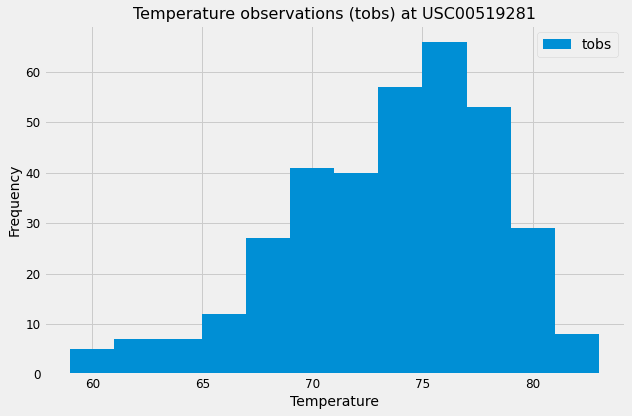

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_tobs = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= date_oneyearago)\
                                        & (measurement.date <= last_dt)).all())

most_active_tobs.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {most_active_station}", fontsize=16)

plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


# Close session

In [ ]:
# Close Session
session.close()